# 遗传算法学习

遗传算法（Genetic Algorithm）是美国J.Holland教授于1975年首先提出的借鉴生物进化规律（适者生存，优胜劣汰遗传机制）演化而来的随机化搜索方法，目前已被广泛地应用于组合优化、机器学习、信号处理、自适应控制和人工生命等领域。

### 0 基本原理

经典遗传算法基本过程：

- 生成初始种群
- 选择、交叉、变异操作生成下一代种群
- 重复流程

其中一些关键术语如下：

- `种群（Population）` 参与演化的生物群体，即解的搜索空间
  - `个体（Individual）` 种群的每一个成员，对应每一个可能的解
  - `染色体（Chromosome）` 对应问题的解向量
  - `基因（Gene）` 解向量的一个分量，或者编码后的解向量的一位
  - `适应度（Fitness）` 体现个体的生存能力，与目标函数相关的函数
- `遗传算子（Operator）` 个体的演化操作，包括选择、交叉、变异
  - `选择(Selection)` 基于适应度的优胜劣汰，以一定的概率从种群中选择若干个体
  - `交叉(Crossover)` 两个染色体进行基因重组
  - `变异(Mutation)` 单个染色体的基因以较低概率发生随机变化

初始种群产生了一系列随机解，选择操作保证了搜索的方向性，交叉和变异拓宽了搜索空间，其中交叉操作延续父辈个体的优良基因，变异操作则可能产生比当前优势基因更优秀的个体。变异操作有利于跳出局部最优解，同时增加了随机搜索的概率，即容易发散。

遗传算法需要在过早收敛（早熟）和发散、精度和效率之间平衡。当物种多样性迅速降低即个体趋于一致，例如选择操作时过分突出优势基因的地位，结果可能只是收敛于局部最优解。当物种持续保持多样性，例如选择力度不大、变异概率太大，结果可能很难收敛，即算法效率较低。

In [1]:
import numpy as np
import copy 


### 1 种群

目前仅考虑浮点数编码，因此省去了编码/解码过程——整个染色体就是解向量，每个基因是其中一个分量。

`Individual`类表征个体，重要的属性为：
  - `solution` 解向量
  - `evaluation` 目标函数值
  - `fitness` 适应度值
  
`Population`类表征群体，根据个体实例生成指定大小的种群，其中：

  - `individuals` 所有个体列表，Numpy的ndarray类型
  - `best` 最优个体

In [2]:
class Individual:
    def __init__(self, ranges):
        '''
        ranges: element range of solution, e.g. [(lb1, ub1), (lb2, ub2), ...]
        validation of ranges is skipped...
        '''
        self.ranges = np.array(ranges)
        self.dimension = self.ranges.shape[0]
        
        # 初始化解向量
        seeds = np.random.random(self.dimension)
        lb = self.ranges[:, 0]
        ub = self.ranges[:, 1]
#         print("seeds",seeds)
        self._selution = lb + (ub-lb)*seeds
#         print("self._solution",self._selution)
        
        # 评估与适应度
        self.evaluation = None
        self.fitness = None
        
    @property
    def solution(self):
        return self._selution
    
    @solution.setter
    def solution(self, solution):
        assert self.dimension == solution.shape[0]
        assert (solution>=self.ranges[:,0]).all() and (solution<=self.ranges[:,1]).all()
        self._selution = solution
    
class Population:
    def __init__(self, individual, size=50):
        '''
        individual: 个体
        size: 个体数量
        '''
        self.individual = individual
        self.size = size
        self.individuals = None
        
    def initialize(self):
        '''初始化下一代'''
        IndvClass = self.individual.__class__
        self.individuals = np.array([IndvClass(self.individual.ranges) for i in range(self.size)], dtype=IndvClass)
        
    def best(self, fun_evaluation, fun_fitness=None):
        '''得到最好的个体'''
        _, evaluation = self.fitness(fun_evaluation, fun_fitness)
        pos = np.argmin(evaluation)
        return self.individuals[pos]
    
    def fitness(self, fun_evaluation, fun_fitness=None):
        '''
        为每个个体计算目标值和适应度
        fun_evaluation: 目标函数 
        fun_fitness: 有估计值计算适应度 
        '''
        if not fun_fitness:
            fun_fitness = lambda x:x 
        
        evaluation = np.array([fun_evaluation(I.solution) if I.evaluation is None else I.evaluation for I in self.individuals])
#         print(evaluation.shape)
            
        fitness = fun_fitness(evaluation)
        fitness /= np.sum(fitness)
#         print(fitness.shape)
        
        for I,e,f in zip(self.individuals, evaluation, fitness):
            I.evaluation = e 
            I.fitness = f 
            
        return fitness, evaluation
        
        

In [3]:
def test():
    ranges = [(-10,10)] * 3
    obj = lambda x:x[0]+x[1]**2 + x[2]**3
    
    I = Individual(ranges)
    P = Population(I, 100)
    P.initialize()
    
    print(P.best(obj).solution)

test()

[-3.7010949  -8.85063272 -9.18061057]


### 2 遗传算子

#### 2.1 选择

采用标准的`轮盘赌（RouletteWheel）`方式，以种群中个体的适应度为参考，从中选择出同样大小的新的种群个体。从上一节种群适应度的计算可知，个体的适应度已经被归一化，因此可以直接作为轮盘赌的概率参考。

In [4]:
#=====================选择==========================
class Selection:
    '''选择操作的基类'''
    def select(self, population, fitness):
        raise NotImplementedError
        
class RouletteWheelSelection(Selection):
    '''
    用轮盘赌选择群体  
    群体中使用适应度函数选择个体 
    '''
    def select(self, population, fitness):
        selected_individuals = np.random.choice(population.individuals, population.size, p=fitness)
        
        population.individuals = np.array([copy.deepcopy(I) for iI in selected_individuals])

#### 交叉

从选择后的样本中随机选择两个个体`a`和`b`，以一定的概率进行交叉操作：将随机位置的对应基因（例如$g_a$，$g_b$）按系数$\alpha$进行线性插值，其余位置保持不变，从而得到两个新的个体`a'`和`b'`。

对于交叉位置的基因：

$$
g_a' = g_a + (g_b-g_a)(1-\alpha)\\
g_b' = g_b - (g_b-g_a)(1-\alpha)
$$

对于非交叉位置的基因：

$$
g_a' = g_a\\
g_b' = g_b
$$

综合起来，个体a和b所有位置的基因交叉操作可以写成向量形式：

$$
a' = a+(b-a)(1-\alpha)\beta\\
b' = b-(b-a)(1-\alpha)\beta
$$

其中，$\beta$表示是否进行交叉的`0-1`向量。

In [5]:
#=====================交叉==========================
class Crossover:
    def __init__(self, rate=0.8, alpha=0.5):
        '''
        rate: 交叉概率 
        alpha: '''
        self.rate = rate
        self.alpha = alpha
        
    @staticmethod
    def cross_individuals(individual_a, individual_b, alpha):
        '''交叉操作
        alpha: 线性插值银因子，当alpha=0.0， 两个基因焦交换
        '''
        pos = np.random.rand(individual_a.dimension) <= 0.5

        temp = (individual_b.solution - individual_a.solution)*pos * (1-alpha)
        new_value_a = individual_a.solution + temp
        new_value_b = individual_b.solution - temp

        new_individual_a = Individual(individual_a.ranges)
        new_individual_b = Individual(individual_b.ranges)

        new_individual_a.solution = new_value_a
        new_individual_b.solution = new_value_b

        return new_individual_a, new_individual_b
        
    def cross(self, population):
        new_individuals = []
        random_population = np.random.permutation(population.individuals)
        num = int(population.size/2.0)+1

        for individual_a,individual_b in zip(population.individuals[0:num+1], random_population[0:num+1]):
            if np.random.rand() <= self.rate:
                child_individuals = self.cross_individuals(individual_a, individual_b, self.alpha)
                new_individuals.extend(child_individuals)
            else: 
                new_individuals.append(individual_a)
                new_individuals.append(individual_b)

        population.individuals = np.array(new_individuals[0: population.size+1])
#         print(population.individuals)

#### 2.3变异

浮点数编码个体的变异操作为将随即位置的基因`g`增加或减少一个随机值。这个随机值由允许变化区间乘以一个`[0,1]`区间的随机数$\alpha$来确定。例如基因`g`的区间为`[L,U]`，则变异后的基因`g'`：

$$
g=g-(g-L)\alpha , (rand()<=0.5) \\
g=g+(U-g)\alpha , (rand()>=0.5)
$$

In [6]:
#=====================变异==========================
class Mutation:
    def __init__(self, rate):
        self.rate = rate
        
    def mutate_individual(self, individual, positions, alpha):
        '''
        positions: 变异位置， list 
        alpha： 变异量
        '''
        for pos in positions:
            if np.random.rand() < 0.5:
                individual.solution[pos] -= (individual.solution[pos]-individual.ranges[:,0][pos])*alpha
            else:
                individual.solution[pos] += (individual.ranges[:,1][pos]-individual.solution[pos])*alpha
                
        individual.evaluation = None
        individual.fitness = None
        
    def mutate(self, population, alpha):
        '''alpha： 变异量'''
        for individual in population.individuals:
            if np.random.rand() > self.rate:
                continue
#             print(individual)
            num = np.random.randint(individual.dimension)+1
            pos = np.random.choice(individual.dimension, num, replace=False)
            self.mutate_individual(individual, pos, alpha)
    

### 3. 遗传算法

本次实现的遗传算法默认求最小值，因此适应度函数应为目标函数值的反函数。并且考虑到它将作为选择概率，即函数值应非负。于是，此处设置为如下形式：
$$
f(x) = arctan(-x) + \pi
$$

In [9]:
class GA:
    def __init__(self, population, selection, crossover, mutation, fun_fitness=lambda x:np.arctan(-x)+np.pi):
        self.population = population
        self.selection = selection
        self.crossover = crossover
        self.mutation = mutation
        self.fun_fitness = fun_fitness
        
    def run(self, fun_evaluation, gen=50):
        self.population.initialize()
        
        for n in range(1, gen+1):
            fitness, _ = self.population.fitness(fun_evaluation, self.fun_fitness)
            self.selection.select(self.population, fitness)
            
            self.crossover.cross(self.population)
            
            self.mutation.mutate(self.population, np.random.rand())
            
        return self.population.best(fun_evaluation, self.fun_fitness)
        

### 4 测试

采用二元函数`Schaffer_N4`进行测试，最小值点$f(0,1.25313)=0.292579$。

$$
f(x,y) = 0.5+\frac{cos^2 [sin(|x^2-y^2|)] - 0.5}{[1+0.001(x^2+y^2)]^2} , (-10<=(x,y)<=10)
$$

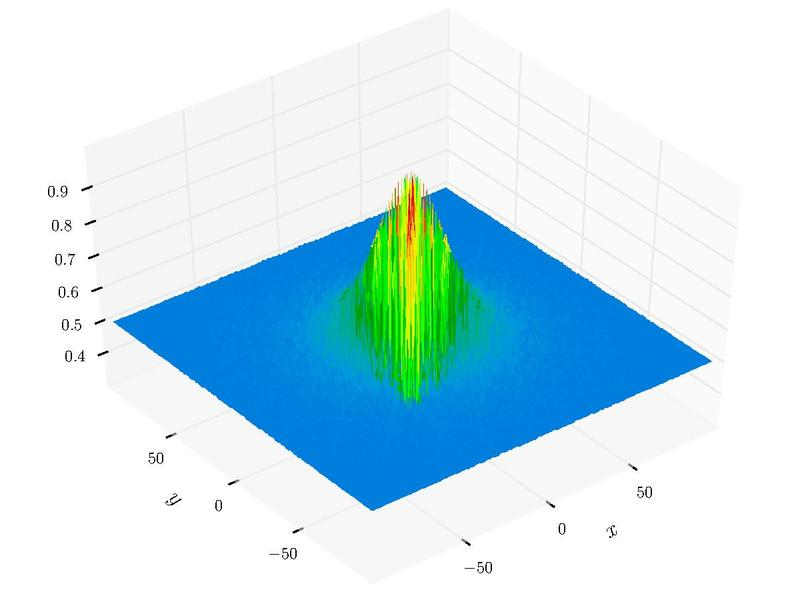

In [15]:
schaffer_n4 = lambda x: 0.5 + (np.cos(np.sin(abs(x[0]**2-x[1]**2)))**2-0.5) / (1.0+0.001*(x[0]**2+x[1]**2))**2  

I = Individual([(-10,10)]*2)
P = Population(I, 50)
S = RouletteWheelSelection()
C = Crossover(0.9, 0.8)
M = Mutation(0.2)
g = GA(P, S, C, M)

res = []
for i in range(10):
    res.append(g.run(schaffer_n4, 500).evaluation)

val = schaffer_n4([0,1.25313])
val_ga = sum(res)/len(res)



In [16]:
print('the minimum: {0}'.format(val))
print('the GA minimum: {0}'.format(val_ga))
print('error: %.3f%%' % ((val_ga/val-1.0)*100))

the minimum: 0.29257863204552975
the GA minimum: 0.3316613408918895
error: 13.358%


### 参考资料
- [遗传算法-基本原理及Python实现](https://dothinking.github.io/blog/2018/10/21/%E9%81%97%E4%BC%A0%E7%AE%97%E6%B3%95-%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86%E5%8F%8APython%E5%AE%9E%E7%8E%B0.html)
- [遗传算法GA(Genetic Algorithm)入门知识梳理](https://segmentfault.com/a/1190000004155021#articleHeader18)
- [遗传算法详解（GA）](https://blog.csdn.net/u010451580/article/details/51178225)